# Q-Learning Agent for Stock Trading

This Q-learning agent is designed to make stock trading decisions based on historical price data. The agent learns an optimal trading strategy through interaction with the market environment using the Q-learning algorithm.

## Agent Architecture

The agent consists of a deep neural network that takes in a state representation and outputs Q-values for each possible action. The state is represented by a sliding window of price differences over a specified window size. The neural network architecture includes an input layer, a hidden layer with ReLU activation, and an output layer with linear activation.

## Q-Learning Process

The Q-learning process follows these steps:

1. **Initialization**: The agent's neural network is initialized with random weights, and the replay memory is emptied.

2. **State Representation**: At each time step, the agent observes the current state of the market, which is represented by a sliding window of price differences.

3. **Action Selection**: The agent selects an action (buy, sell, or hold) based on an epsilon-greedy policy. With probability epsilon, the agent explores by selecting a random action, and with probability 1-epsilon, the agent exploits by selecting the action with the highest Q-value.

4. **State Transition**: The agent executes the selected action and observes the next state and the reward received from the market.

5. **Replay Memory**: The agent stores the transition (state, action, reward, next state, done) in the replay memory.

6. **Q-Value Update**: The agent samples a batch of transitions from the replay memory and updates the Q-values using the Q-learning update rule. The target Q-value for each transition is calculated based on the reward and the maximum Q-value of the next state.

7. **Neural Network Update**: The agent's neural network is updated using the sampled batch of transitions and the Q-learning loss function. The optimizer adjusts the network's weights to minimize the loss.

8. **Iteration**: Steps 3-7 are repeated for a specified number of episodes or until convergence.

## Trading Simulation

The trading simulation is performed using the trained Q-learning agent. The agent makes buy and sell decisions based on the current state of the market. The state is represented by a sliding window of price differences.

The agent's decisions are as follows:

- **Buy**: If the agent selects the buy action and there is sufficient funds, a unit of stock is purchased, and the inventory and balance are updated accordingly.

- **Sell**: If the agent selects the sell action and there is stock in the inventory, a unit of stock is sold, and the balance is updated based on the selling price.

- **Hold**: If the agent selects the hold action, no action is taken.

The simulation keeps track of the buying and selling states, total gains, investment percentage, and the number of shares held at the end.

## Usage

To use the Q-learning agent:

1. Prepare the historical price data as a list of closing prices.

2. Set the initial parameters, such as the initial money, window size, and skip size.

3. Create an instance of the `Agent` class with the desired state size, window size, trend, skip size, batch size, and device.

4. Call the `train` method to train the agent for a specified number of iterations.

5. Evaluate the agent's performance using the `buy` method, which returns the buy and sell states, total gains, investment percentage, and the number of shares held.

The Q-learning agent provides a reinforcement learning approach to optimize a trading strategy based on historical price data. By interacting with the market environment and learning from its experiences, the agent aims to make profitable trading decisions.

In [3]:
!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 39.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 60.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 33.9 MB/s eta 0:00:00


In [1]:
from utils import *
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [2]:
# stock configs
ticker = ['GOOG']
start_date = '2022-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [3]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(504, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-04-01,140.009995,140.949997,138.796997,140.699997,23480000,0.0,0.0
1,2022-04-04,140.824493,144.043747,140.824493,143.642502,19076000,0.0,0.0
2,2022-04-05,143.399506,143.589996,140.943497,141.063004,19256000,0.0,0.0
3,2022-04-06,139.161499,139.848495,136.418106,137.175995,23574000,0.0,0.0
4,2022-04-07,136.617996,137.701508,134.857254,136.464996,19448000,0.0,0.0


In [4]:
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size, device):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = []
        self.inventory = []
        self.device = device

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.model = nn.Sequential(
            nn.Linear(self.state_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.action_size)
        ).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        return self.model(state).argmax().item()

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        new_states = torch.tensor(new_states, dtype=torch.float32).to(self.device)
        
        Q = self.model(states)
        Q_new = self.model(new_states)
        
        X = states
        y = Q.clone().detach()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = reward
            if not done:
                target += self.gamma * torch.max(Q_new[i])
            y[i][action] = target

        loss = self.loss_fn(Q, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)

        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f' % (t, self.trend[t], invest, initial_money))

            state = next_state

        shares_held = len(inventory)
        if shares_held > 0:
            current_price = self.trend[-1]
            equity_value = shares_held * current_price
            total_gains = initial_money + equity_value - starting_money
            invest = ((initial_money + equity_value - starting_money) / starting_money) * 100
        else:
            total_gains = initial_money - starting_money
            invest = ((initial_money - starting_money) / starting_money) * 100

        print(inventory)
        return states_buy, states_sell, total_gains, invest, shares_held

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money

            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state

                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)

            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f' % (i + 1, total_profit, cost, starting_money))

In [6]:
close = data.Close.values.tolist()

initial_money = 10000
window_size = 30
skip = 1
batch_size = 32

# Determine the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Agent
agent = Agent(state_size=window_size,
              window_size=window_size,
              trend=close,
              skip=skip,
              batch_size=batch_size,
              device=device)

In [14]:
# Train the agent
agent.train(iterations=50, checkpoint=10, initial_money=initial_money)

epoch: 10, total rewards: 151.604988.3, cost: 0.000101, total money: 10151.604988
epoch: 20, total rewards: 102.363007.3, cost: 0.000077, total money: 10102.363007
epoch: 30, total rewards: 64.975494.3, cost: 0.000041, total money: 10064.975494
epoch: 40, total rewards: 60.331497.3, cost: 0.000164, total money: 10060.331497
epoch: 50, total rewards: 65.622505.3, cost: 0.000218, total money: 10065.622505


In [15]:
# Evaluate the agent's performance
states_buy, states_sell, total_gains, invest, shares_held = agent.buy(initial_money)

day 7: buy 1 unit at price 128.374496, total balance 9871.625504
day 9: buy 1 unit at price 127.252998, total balance 9744.372505
day 10, sell 1 unit at price 127.960999, investment -0.322103 %, total balance 9872.333504
day 11: buy 1 unit at price 130.531006, total balance 9741.802498
day 12, sell 1 unit at price 128.245499, investment 0.779943 %, total balance 9870.047997
day 13, sell 1 unit at price 124.937500, investment -4.285193 %, total balance 9994.985497
day 15: buy 1 unit at price 123.250000, total balance 9871.735497
day 18: buy 1 unit at price 119.411499, total balance 9752.323997
day 19, sell 1 unit at price 114.966499, investment -6.720893 %, total balance 9867.290497
day 20, sell 1 unit at price 117.156998, investment -1.888010 %, total balance 9984.447495
day 22: buy 1 unit at price 122.574997, total balance 9861.872498
day 23, sell 1 unit at price 116.746498, investment -4.755047 %, total balance 9978.618996
day 31: buy 1 unit at price 116.701500, total balance 9861.91

In [17]:
import plotly.graph_objects as go

starting_money = 10000

close = data['Close']
final_share_price = close[len(close) - 1]  # Final share price
total_portfolio_value = starting_money + shares_held * final_share_price
total_gains = total_portfolio_value - starting_money

fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close']))

# Buy signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_buy],
                         y=[close[i] for i in states_buy],
                         mode='markers',
                         name='Buy Signals',
                         marker=dict(symbol='triangle-up', size=10, color='green')))

# Sell signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_sell],
                         y=[close[i] for i in states_sell],
                         mode='markers',
                         name='Sell Signals',
                         marker=dict(symbol='triangle-down', size=10, color='red')))

# Set layout
fig.update_layout(
    title=f'Total Gains: {total_gains:.2f}, Total Portfolio Value: {total_portfolio_value:.2f}',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    legend=dict(x=0, y=1, orientation='h')
)

fig.show()

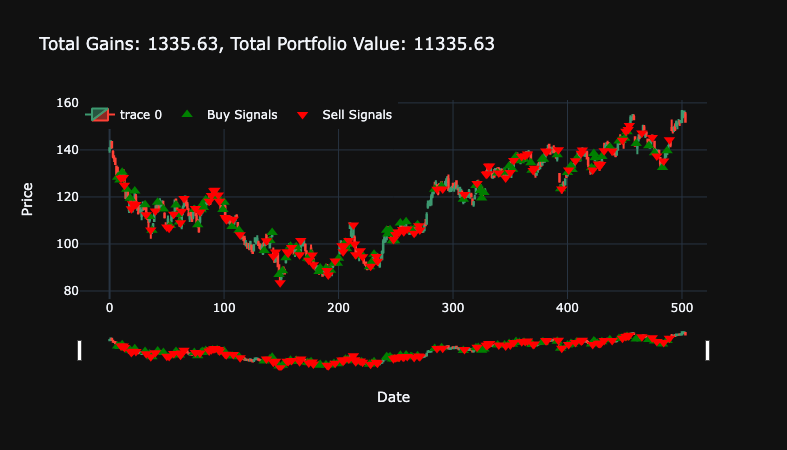